<a href="https://colab.research.google.com/github/hideonbushes-maker/SNN-wafermap/blob/master/%EB%82%98%EB%85%B8%EC%86%8C%EC%9E%90_project2_Q2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import numpy as np

# ——————————————
# 1) CSV 읽기
# ——————————————
df_low  = pd.read_csv("prob1_bulk_low.csv")
df_high = pd.read_csv("prob1_bulk_high.csv")

# ——————————————
# 2) 페어 개수 자동 계산
# ——————————————
n_low  = df_low.shape[1]  // 2
n_high = df_high.shape[1] // 2
n_sweeps = min(n_low, n_high)

# ——————————————
# 3) Vth 추출: gm-extrap 함수
# ——————————————
def extract_vth_gmextrap(Vgs, Ids):
    # 1) 정렬
    order = np.argsort(Vgs)
    V = Vgs[order]
    I = Ids[order]

    # 2) 미분(전도도 gm) 계산: 중앙차분
    gm = np.gradient(I, V)

    # 3) 최대 gm 지점 찾기
    j = np.nanargmax(gm)

    # 4) tangent-extrapolation: Vth = Vj – Ij/gmj
    Vth = V[j] - I[j] / gm[j]
    return Vth

# ——————————————
# 4) Low/High Vth, DIBL 계산
# ——————————————
I_spec = 1e-7    # (not used here)
VDS_low, VDS_high = 0.05, 0.7

Vth_low  = []
Vth_high = []
for i in range(n_sweeps):
    # low-VDS sweep
    V_lo = df_low.iloc[:,2*i   ].values
    I_lo = df_low.iloc[:,2*i+1 ].values
    Vth_low.append(extract_vth_gmextrap(V_lo, I_lo))

    # high-VDS sweep
    V_hi = df_high.iloc[:,2*i   ].values
    I_hi = df_high.iloc[:,2*i+1 ].values
    Vth_high.append(extract_vth_gmextrap(V_hi, I_hi))

Vth_low  = np.array(Vth_low)
Vth_high = np.array(Vth_high)

DIBL = (Vth_low - Vth_high)/(VDS_high - VDS_low)*1e3   # mV/V

# ——————————————
# 5) 결과 출력
# ——————————————
# t_ox 리스트 (실제 값으로 교체)
t_ox_all = [1,1.5,2,2.5,3,4,10,20]
t_ox = t_ox_all[:len(DIBL)]

print("t_ox |   Vth_low   |  Vth_high   |  DIBL (mV/V)")
for tox, vl, vh, d in zip(t_ox, Vth_low, Vth_high, DIBL):
    print(f"{tox:>4}nm | {vl:8.4f} V | {vh:8.4f} V | {d:7.1f}")

t_ox |   Vth_low   |  Vth_high   |  DIBL (mV/V)
   1nm |   0.5661 V |   0.2905 V |   424.0


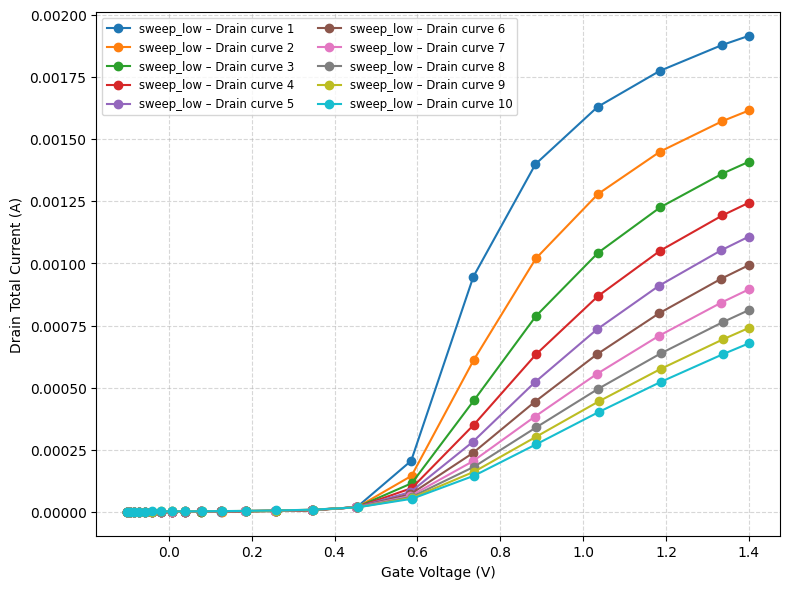

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 그릴 CSV 파일 리스트 (고정된 파일명이면 glob 불필요)
csv_files = ['sweep_low.csv']

plt.figure(figsize=(8,6))

for fname in csv_files:
    df = pd.read_csv(fname)
    label_base = fname.replace('.csv','')
    for i in range(1, 11):
        x = df[f'gate{i}']
        y = df[f'cur{i}']
        plt.plot(x, y,
                 marker='o', linestyle='-',
                 label=f'{label_base} – Drain curve {i}')

plt.xlabel('Gate Voltage (V)')
plt.ylabel('Drain Total Current (A)')
plt.yscale('linear')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

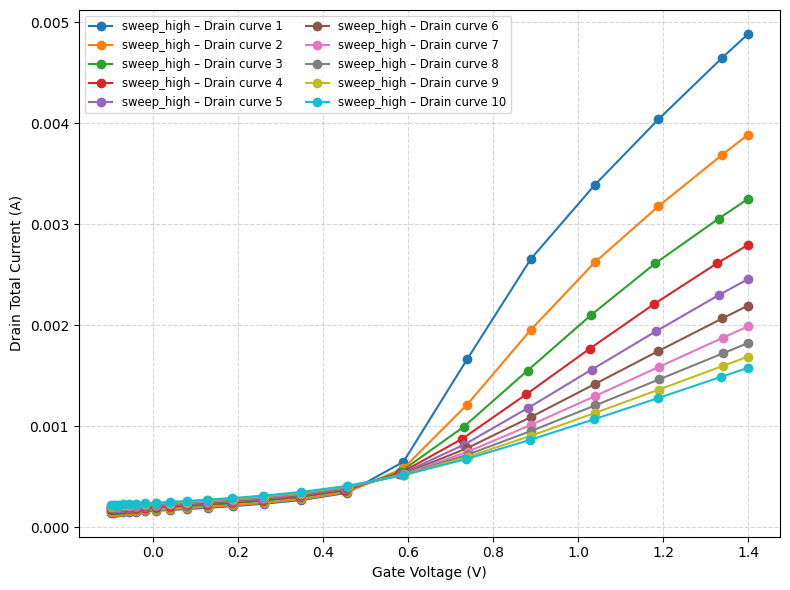

In [43]:
csv_files = ['sweep_high.csv']
plt.figure(figsize=(8,6))

for fname in csv_files:
    df = pd.read_csv(fname)
    label_base = fname.replace('.csv','')
    for i in range(1, 11):
        x = df[f'gate{i}']
        y = df[f'cur{i}']
        plt.plot(x, y,
                 marker='o', linestyle='-',
                 label=f'{label_base} – Drain curve {i}')

plt.xlabel('Gate Voltage (V)')
plt.ylabel('Drain Total Current (A)')
plt.yscale('linear')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

In [64]:
"""
선형 보간(linear interpolation) -> Bulk model에서는 DIBL 찾기 불가능함.
"""
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# 1) 데이터 불러오기 (파일명/경로에 맞게 수정)

df_low  = pd.read_csv('sweep_low_bulk.csv')
df_high = pd.read_csv('sweep_high_bulk.csv')

# 2) sweep 개수 자동 계산 (gate/cur 페어 수)
n_sweeps = df_low.shape[1] // 2

# 3) 파라미터
I_spec   = 1e-7    # [A] 기준 전류
VDS_low  = 0.05    # [V] low-VDS
VDS_high = 0.7     # [V] high-VDS

# 4) 순수 선형 보간으로 Vth 추출 함수
def extract_vth_linear(Vgs, Ids, I_spec):
    # Ids가 증가하도록 정렬
    order = np.argsort(Ids)
    I_s   = Ids[order]
    V_s   = Vgs[order]
    # np.interp은 I_spec이 범위 밖이면 가장 가까운 끝점 값을 리턴
    return float(np.interp(I_spec, I_s, V_s))

# 5) 각 sweep마다 Vth_low / Vth_high 계산
Vth_low  = []
Vth_high = []
for i in range(n_sweeps):
    # low-VDS sweep: gate 컬럼은 2*i, cur 컬럼은 2*i+1
    V_low = df_low .iloc[:, 2*i    ].values
    I_low = df_low .iloc[:, 2*i + 1].values
    Vth_low .append(extract_vth_linear(V_low, I_low, I_spec))

    # high-VDS sweep
    V_high = df_high.iloc[:, 2*i    ].values
    I_high = df_high.iloc[:, 2*i + 1].values
    Vth_high.append(extract_vth_linear(V_high, I_high, I_spec))

Vth_low  = np.array(Vth_low)
Vth_high = np.array(Vth_high)

# 6) DIBL 계산 [mV/V]
DIBL = (Vth_low - Vth_high) / (VDS_high - VDS_low) * 1e3

# 1) t_ox 리스트 정의 (nm 단위)
t_ox_all = [0.2, 0.4, 0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]

# 2) DIBL 개수만큼 잘라 내기
t_ox = t_ox_all[:len(DIBL)]

# 3) 결과 함께 출력
print("t_ox (nm) |   Vth_low   |  Vth_high   |  DIBL (mV/V)")
for tox, vl, vh, d in zip(t_ox, Vth_low, Vth_high, DIBL):
    print(f"{tox:>8.1f} | {vl:8.4f} V | {vh:8.4f} V | {d:7.1f}")

t_ox (nm) |   Vth_low   |  Vth_high   |  DIBL (mV/V)
     0.2 |  -0.1000 V |  -0.1000 V |     0.0
     0.4 |  -0.1000 V |  -0.1000 V |     0.0
     0.6 |  -0.1000 V |  -0.1000 V |     0.0
     0.8 |  -0.1000 V |  -0.1000 V |     0.0
     1.0 |  -0.1000 V |  -0.1000 V |     0.0
     1.2 |  -0.1000 V |  -0.1000 V |     0.0
     1.4 |  -0.1000 V |  -0.1000 V |     0.0
     1.6 |  -0.1000 V |  -0.1000 V |     0.0
     1.8 |  -0.1000 V |  -0.1000 V |     0.0
     2.0 |  -0.1000 V |  -0.1000 V |     0.0


In [71]:
import pandas as pd
import numpy as np

# ——————————————
# 1) CSV 읽기
# ——————————————
df_low  = pd.read_csv('sweep_low_bulk.csv')
df_high = pd.read_csv('sweep_high_bulk.csv')

# ——————————————
# 2) sweep 개수
# ——————————————
n_sweeps = df_low.shape[1] // 2

# ——————————————
# 3) Transconductance-extrapolation 함수
# ——————————————
def extract_vth_gm_norm(Vgs, Ids, I_spec=1e-7, I_cut=1e-5):
    """
    1) Vgs/Ids 정렬
    2) sub-threshold: Ids < I_cut 영역만 선택
    3) normalized gm = d(ln I)/dV 계산 (np.gradient)
    4) 최대 gm 지점 j
    5) tangent of lnI: ln I ≈ gm_j*(V - V_j) + ln I_j
       → Vth = V_j + (ln I_spec - ln I_j)/gm_j
    """
    V = np.array(Vgs)
    I = np.array(Ids)
    order = np.argsort(V)
    V, I = V[order], I[order]

    # sub-threshold 데이터만
    mask = I < I_cut
    if mask.sum() < 3:
        # 너무 데이터가 없으면 전체로 fallback
        mask[:] = True

    Vsub = V[mask]
    Isub = I[mask]
    lnI  = np.log(Isub)

    # normalized gm
    gm_norm = np.gradient(lnI, Vsub)
    j = np.nanargmax(gm_norm)

    # tangent extrapolation to I_spec
    return Vsub[j] + (np.log(I_spec) - lnI[j]) / gm_norm[j]

# ——————————————
# 4) Vth_low/Vth_high 계산
# ——————————————
I_spec   = 1e-7     # [A]
VDS_low  = 0.05     # [V]
VDS_high = 0.7      # [V]

Vth_low  = []
Vth_high = []
for i in range(n_sweeps):
    # low-VDS
    V_lo = df_low .iloc[:,2*i   ].values
    I_lo = df_low .iloc[:,2*i+1 ].values
    Vth_low .append(extract_vth_gm_norm(V_lo, I_lo, I_spec))

    # high-VDS
    V_hi = df_high.iloc[:,2*i   ].values
    I_hi = df_high.iloc[:,2*i+1 ].values
    Vth_high.append(extract_vth_gm_norm(V_hi, I_hi, I_spec))

Vth_low  = np.array(Vth_low)
Vth_high = np.array(Vth_high)

# ——————————————
# 5) DIBL 계산
# ——————————————
DIBL = (Vth_low - Vth_high) / (VDS_high - VDS_low) * 1e3   # [mV/V]

# ——————————————
# 6) t_ox 리스트 (nm 단위)
# ——————————————
t_ox_all = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]  # 실제 값
t_ox = t_ox_all[:len(DIBL)]

# ——————————————
# 7) 결과 출력
# ——————————————
print("t_ox(nm) |   Vth_low   |  Vth_high   |  DIBL (mV/V)")
for tox, vl, vh, d in zip(t_ox, Vth_low, Vth_high, DIBL):
    print(f"{tox:7.1f} | {vl:8.4f} V | {vh:8.4f} V | {d:8.1f}")

t_ox(nm) |   Vth_low   |  Vth_high   |  DIBL (mV/V)
    0.2 |  -0.3578 V |  -0.9938 V |    978.5
    0.4 |  -0.3904 V |  -1.3948 V |   1545.2
    0.6 |  -0.4673 V |  -1.8462 V |   2121.4
    0.8 |  -0.5023 V |  -2.2215 V |   2644.9
    1.0 |  -0.5366 V |  -2.5549 V |   3105.0
    1.2 |  -0.5685 V |  -2.8780 V |   3553.1
    1.4 |  -0.6010 V |  -3.2121 V |   4017.2
    1.6 |  -0.6279 V |  -3.5439 V |   4486.2
    1.8 |  -0.6571 V |  -3.8710 V |   4944.5
    2.0 |  -0.8882 V |  -4.1980 V |   5092.0


In [73]:
import pandas as pd
import numpy as np

# 1) CSV 읽기
df_low  = pd.read_csv('sweep_low_bulk.csv')
df_high = pd.read_csv('sweep_high_bulk.csv')

# 2) sweep 페어 수
n_sweeps = df_low.shape[1] // 2

# 3) Raw gm-extrap 함수 (extrapolate to I_spec)
def extract_vth_gm_raw(Vgs, Ids, I_spec=1e-7):
    # 1) 정렬
    V = np.array(Vgs)
    I = np.array(Ids)
    order = np.argsort(V)
    V, I = V[order], I[order]

    # 2) raw gm = dI/dV
    gm = np.gradient(I, V)

    # 3) gm 최대 인덱스
    j = np.nanargmax(gm)

    # 4) tangent extrapolate to I_spec:
    #    I ≈ I_j + gm_j*(V - V_j)
    #    → Vth = V_j + (I_spec - I_j)/gm_j
    return V[j] + (I_spec - I[j]) / gm[j]

# 4) Low/High Vth 계산
I_spec   = 1e-7
VDS_low  = 0.05
VDS_high = 0.7

Vth_low, Vth_high = [], []
for i in range(n_sweeps):
    # low-VDS
    V_lo = df_low .iloc[:,2*i   ].values
    I_lo = df_low .iloc[:,2*i+1 ].values
    Vth_low.append(extract_vth_gm_raw(V_lo, I_lo, I_spec))

    # high-VDS
    V_hi = df_high.iloc[:,2*i   ].values
    I_hi = df_high.iloc[:,2*i+1 ].values
    Vth_high.append(extract_vth_gm_raw(V_hi, I_hi, I_spec))

Vth_low  = np.array(Vth_low)
Vth_high = np.array(Vth_high)

# 5) DIBL 계산
DIBL = (Vth_low - Vth_high)/(VDS_high - VDS_low)*1e3  # mV/V

# 6) t_ox 리스트
t_ox_all = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
t_ox = t_ox_all[:len(DIBL)]

# 7) 결과 출력
print("t_ox(nm) | Vth_low | Vth_high | DIBL(mV/V)")
for tox, vl, vh, d in zip(t_ox, Vth_low, Vth_high, DIBL):
    print(f"{tox:8.1f} | {vl:8.4f} V | {vh:8.4f} V | {d:8.1f}")

t_ox(nm) | Vth_low | Vth_high | DIBL(mV/V)
     0.2 |   0.4969 V |   0.4907 V |      9.5
     0.4 |   0.5259 V |   0.4720 V |     82.8
     0.6 |   0.5360 V |   0.4613 V |    114.9
     0.8 |   0.5401 V |   0.4357 V |    160.7
     1.0 |   0.5375 V |   0.4137 V |    190.5
     1.2 |   0.5487 V |   0.3887 V |    246.2
     1.4 |   0.5560 V |   0.3635 V |    296.1
     1.6 |   0.5608 V |   0.3392 V |    341.0
     1.8 |   0.5641 V |   0.3178 V |    379.0
     2.0 |   0.5662 V |   0.2906 V |    424.1


Fitted A     = 3.51e+03
Fitted α     = 9.07e-01


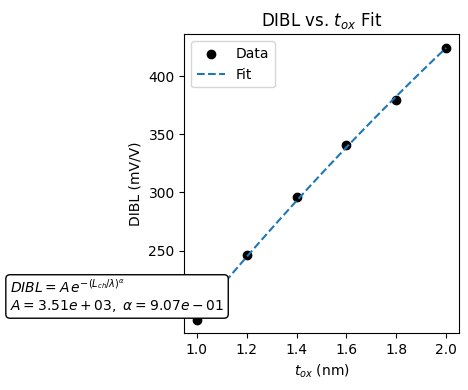

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1) 실험 데이터: t_ox (nm) 과 대응하는 DIBL (mV/V)
t_ox = np.array([1.0, 1.2, 1.4, 1.6, 1.8,2.0])       # 예시: 실제 데이터로 교체
DIBL = np.array([190.5, 246.2, 296.1, 341.0, 379.0, 424.1])  # 예시

# 2) 물리 모델 정의
#    DIBL(t_ox) = A * exp [ - (Lch / lambda_char)^alpha ]
#    lambda_char = sqrt( (ε_si/ε_ox) · t_si · t_ox )
Lch      = 25.0     # 채널 길이 (nm)
tsi      = 20.0     # 실리콘 두께 (nm)
eps_ratio = 3     # ε_si/ε_ox

def dibl_model(t, A, alpha):
    lambda_char = np.sqrt(eps_ratio * tsi * t)
    return A * np.exp(- (Lch / lambda_char)**alpha)

# 3) 초기 추정값(p0) 넣고 비선형 최소제곱 피팅
p0 = [2e3, 0.3]   # 대략 A 약 2×10^3, alpha 약 0.3
popt, pcov = curve_fit(dibl_model, t_ox, DIBL, p0=p0)
A_fit, alpha_fit = popt

print(f"Fitted A     = {A_fit:.2e}")
print(f"Fitted α     = {alpha_fit:.2e}")

# 4) 결과 시각화
tx = np.linspace(t_ox.min(), t_ox.max(), 200)
plt.figure(figsize=(6,4))
plt.scatter(t_ox, DIBL, color='k', label='Data')
plt.plot(tx, dibl_model(tx, *popt), '--', label='Fit')
plt.xlabel(r'$t_{ox}$ (nm)')
plt.ylabel('DIBL (mV/V)')
plt.title('DIBL vs. $t_{ox}$ Fit')
plt.text(0.25, plt.ylim()[0]+20,
         rf'$DIBL=A\,e^{{-(L_{{ch}}/\lambda)^{{\alpha}}}}$'+"\n"
         rf'$A={A_fit:.2e},\ \alpha={alpha_fit:.2e}$',
         fontsize=10, bbox=dict(boxstyle="round", fc="w"))
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
import numpy as np

# 피팅 결과 (위 코드 실행 후 얻은 값)
A_fit     = 3.51e3    # 예: 3509.4
alpha_fit = 9.07e-1      # 예: 0.9067

# 모델 상수
Lch       = 25.0   # nm
tsi       = 20.0   # nm
eps_ratio = 3.0    # ε_si/ε_ox 비

# 목표 DIBL 값
D_target = 100.0   # mV/V

# 역식 적용
term = -np.log(D_target / A_fit)
t_ox_target = ( Lch / (term**(1/alpha_fit)) )**2 / (eps_ratio * tsi)

print(f"어림잡아 DIBL=100mV/V 일 때 t_ox ≈ {t_ox_target:.3f} nm")

어림잡아 DIBL=100mV/V 일 때 t_ox ≈ 0.634 nm


*DG*

In [54]:
"""
선형 보간(linear interpolation)
"""
import pandas as pd
import numpy as np

# 1) 데이터 불러오기 (파일명/경로에 맞게 수정)
df_low  = pd.read_csv("sweep_low_dg.csv")    # gate1,cur1 … gate10,cur10
df_high = pd.read_csv("sweep_high_dg.csv")   # gate1,cur1 … gate10,cur10

# 2) sweep 개수 자동 계산 (gate/cur 페어 수)
n_sweeps = df_low.shape[1] // 2

# 3) 파라미터
I_spec   = 1e-7    # [A] 기준 전류
VDS_low  = 0.05    # [V] low-VDS
VDS_high = 0.7     # [V] high-VDS

# 4) 순수 선형 보간으로 Vth 추출 함수
def extract_vth_linear(Vgs, Ids, I_spec):
    # Ids가 증가하도록 정렬
    order = np.argsort(Ids)
    I_s   = Ids[order]
    V_s   = Vgs[order]
    # np.interp은 I_spec이 범위 밖이면 가장 가까운 끝점 값을 리턴
    return float(np.interp(I_spec, I_s, V_s))

# 5) 각 sweep마다 Vth_low / Vth_high 계산
Vth_low  = []
Vth_high = []
for i in range(n_sweeps):
    # low-VDS sweep: gate 컬럼은 2*i, cur 컬럼은 2*i+1
    V_low = df_low .iloc[:, 2*i    ].values
    I_low = df_low .iloc[:, 2*i + 1].values
    Vth_low .append(extract_vth_linear(V_low, I_low, I_spec))

    # high-VDS sweep
    V_high = df_high.iloc[:, 2*i    ].values
    I_high = df_high.iloc[:, 2*i + 1].values
    Vth_high.append(extract_vth_linear(V_high, I_high, I_spec))

Vth_low  = np.array(Vth_low)
Vth_high = np.array(Vth_high)

# 6) DIBL 계산 [mV/V]
DIBL = (Vth_low - Vth_high) / (VDS_high - VDS_low) * 1e3


In [55]:
# 1) t_ox 리스트 정의 (nm 단위)
t_ox_all = [1, 1.5, 2, 2.5, 3, 4, 10, 20]

# 2) DIBL 개수만큼 잘라 내기
t_ox = t_ox_all[:len(DIBL)]

# 3) 결과 함께 출력
print("t_ox (nm) |   Vth_low   |  Vth_high   |  DIBL (mV/V)")
for tox, vl, vh, d in zip(t_ox, Vth_low, Vth_high, DIBL):
    print(f"{tox:>8.1f} | {vl:8.4f} V | {vh:8.4f} V | {d:7.1f}")

t_ox (nm) |   Vth_low   |  Vth_high   |  DIBL (mV/V)
     1.0 |   0.2695 V |   0.2399 V |    45.5
     1.5 |   0.2636 V |   0.1961 V |   103.9
     2.0 |   0.2576 V |   0.1631 V |   145.5
     2.5 |   0.2508 V |   0.1257 V |   192.5
     3.0 |   0.2234 V |   0.0805 V |   219.9
     4.0 |   0.1924 V |  -0.0132 V |   316.4
    10.0 |  -0.0275 V |  -0.1000 V |   111.5
    20.0 |  -0.1000 V |  -0.1000 V |     0.0


t_ox가 10,20nm 에서는 off-current가 1e-7 A 이하로 내려오지 않아 보간 끝점이 그대로 쓰여 버린 인위적 클램핑 값이므로
실제 물리 트렌드와는 무관한 “0 mV/V” 혹은 급감이 나왔습니다.

Fitted A     = 2.64e+03
Fitted α     = 9.06e-01


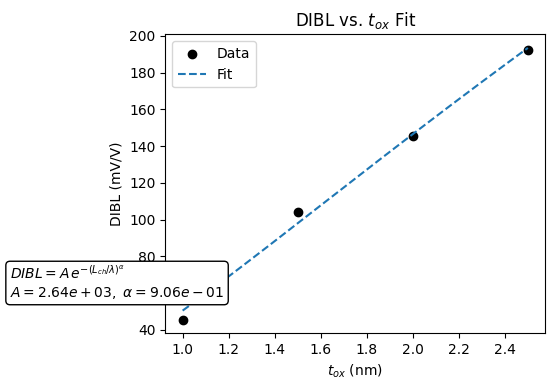

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1) 실험 데이터: t_ox (nm) 과 대응하는 DIBL (mV/V)
t_ox = np.array([1.0, 1.5, 2.0, 2.5])       # 예시: 실제 데이터로 교체
DIBL = np.array([45.5,103.9,145.5,192.5])  # 예시

# 2) 물리 모델 정의
#    DIBL(t_ox) = A * exp [ - (Lch / lambda_char)^alpha ]
#    lambda_char = sqrt( (ε_si/ε_ox) · t_si · t_ox )
Lch      = 25.0     # 채널 길이 (nm)
tsi      = 10.0     # 실리콘 두께 (nm)
eps_ratio = 3     # ε_si/ε_ox

def dibl_model(t, A, alpha):
    lambda_char = np.sqrt(eps_ratio * tsi * t)
    return A * np.exp(- (Lch / lambda_char)**alpha)

# 3) 초기 추정값(p0) 넣고 비선형 최소제곱 피팅
p0 = [2e3, 0.3]   # 대략 A 약 2×10^3, alpha 약 0.3
popt, pcov = curve_fit(dibl_model, t_ox, DIBL, p0=p0)
A_fit, alpha_fit = popt

print(f"Fitted A     = {A_fit:.2e}")
print(f"Fitted α     = {alpha_fit:.2e}")

# 4) 결과 시각화
tx = np.linspace(t_ox.min(), t_ox.max(), 200)
plt.figure(figsize=(6,4))
plt.scatter(t_ox, DIBL, color='k', label='Data')
plt.plot(tx, dibl_model(tx, *popt), '--', label='Fit')
plt.xlabel(r'$t_{ox}$ (nm)')
plt.ylabel('DIBL (mV/V)')
plt.title('DIBL vs. $t_{ox}$ Fit')
plt.text(0.25, plt.ylim()[0]+20,
         rf'$DIBL=A\,e^{{-(L_{{ch}}/\lambda)^{{\alpha}}}}$'+"\n"
         rf'$A={A_fit:.2e},\ \alpha={alpha_fit:.2e}$',
         fontsize=10, bbox=dict(boxstyle="round", fc="w"))
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
import numpy as np

# 피팅 결과 (위 코드 실행 후 얻은 값)
A_fit     = 2.64e+03
alpha_fit = 9.06e-01

# 모델 상수
Lch       = 25.0   # nm
tsi       = 10.0   # nm
eps_ratio = 3.0    # ε_si/ε_ox 비

# 목표 DIBL 값
D_target = 100.0   # mV/V

# 역식 적용
term = -np.log(D_target / A_fit)
t_ox_target = ( Lch / (term**(1/alpha_fit)) )**2 / (eps_ratio * tsi)

print(f"어림잡아 DIBL=100mV/V 일 때 t_ox ≈ {t_ox_target:.3f} nm")

어림잡아 DIBL=100mV/V 일 때 t_ox ≈ 1.520 nm


*UTB-SOI*

In [56]:
"""
선형 보간(linear interpolation)
"""
import pandas as pd
import numpy as np

# 1) 데이터 불러오기 (파일명/경로에 맞게 수정)
df_low  = pd.read_csv("sweep_low_soi.csv")    # gate1,cur1 … gate10,cur10
df_high = pd.read_csv("sweep_high_soi.csv")   # gate1,cur1 … gate10,cur10

# 2) sweep 개수 자동 계산 (gate/cur 페어 수)
n_sweeps = df_low.shape[1] // 2

# 3) 파라미터
I_spec   = 1e-7    # [A] 기준 전류
VDS_low  = 0.05    # [V] low-VDS
VDS_high = 0.7     # [V] high-VDS

# 4) 순수 선형 보간으로 Vth 추출 함수
def extract_vth_linear(Vgs, Ids, I_spec):
    # Ids가 증가하도록 정렬
    order = np.argsort(Ids)
    I_s   = Ids[order]
    V_s   = Vgs[order]
    # np.interp은 I_spec이 범위 밖이면 가장 가까운 끝점 값을 리턴
    return float(np.interp(I_spec, I_s, V_s))

# 5) 각 sweep마다 Vth_low / Vth_high 계산
Vth_low  = []
Vth_high = []
for i in range(n_sweeps):
    # low-VDS sweep: gate 컬럼은 2*i, cur 컬럼은 2*i+1
    V_low = df_low .iloc[:, 2*i    ].values
    I_low = df_low .iloc[:, 2*i + 1].values
    Vth_low .append(extract_vth_linear(V_low, I_low, I_spec))

    # high-VDS sweep
    V_high = df_high.iloc[:, 2*i    ].values
    I_high = df_high.iloc[:, 2*i + 1].values
    Vth_high.append(extract_vth_linear(V_high, I_high, I_spec))

Vth_low  = np.array(Vth_low)
Vth_high = np.array(Vth_high)

# 6) DIBL 계산 [mV/V]
DIBL = (Vth_low - Vth_high) / (VDS_high - VDS_low) * 1e3


In [57]:
# 1) t_ox 리스트 정의 (nm 단위)
t_ox_all = [0.2,0.4,0.6,0.8,1.0]

# 2) DIBL 개수만큼 잘라 내기
t_ox = t_ox_all[:len(DIBL)]

# 3) 결과 함께 출력
print("t_ox (nm) |   Vth_low   |  Vth_high   |  DIBL (mV/V)")
for tox, vl, vh, d in zip(t_ox, Vth_low, Vth_high, DIBL):
    print(f"{tox:>8.1f} | {vl:8.4f} V | {vh:8.4f} V | {d:7.1f}")

t_ox (nm) |   Vth_low   |  Vth_high   |  DIBL (mV/V)
     0.2 |   0.2524 V |   0.0793 V |   266.3
     0.4 |   0.2345 V |   0.0410 V |   297.7
     0.6 |   0.2185 V |   0.0021 V |   333.0
     0.8 |   0.2061 V |  -0.0381 V |   375.7
     1.0 |   0.1960 V |  -0.0789 V |   422.9


Fitted A     = 2.05e+03
Fitted α     = 3.20e-01


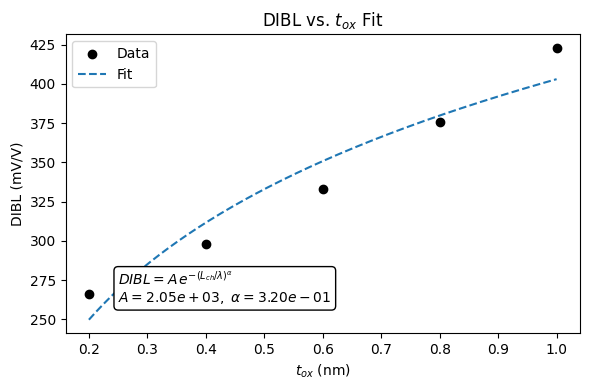

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1) 실험 데이터: t_ox (nm) 과 대응하는 DIBL (mV/V)
t_ox = np.array([0.2,0.4,0.6,0.8,1.0])       # 예시: 실제 데이터로 교체
DIBL = np.array([266.3,297.7,333.0,375.7,422.9])  # 예시

# 2) 물리 모델 정의
#    DIBL(t_ox) = A * exp [ - (Lch / lambda_char)^alpha ]
#    lambda_char = sqrt( (ε_si/ε_ox) · t_si · t_ox )
Lch      = 25.0     # 채널 길이 (nm)
tsi      = 10.0     # 실리콘 두께 (nm)
eps_ratio = 3     # ε_si/ε_ox

def dibl_model(t, A, alpha):
    lambda_char = np.sqrt(eps_ratio * tsi * t)
    return A * np.exp(- (Lch / lambda_char)**alpha)

# 3) 초기 추정값(p0) 넣고 비선형 최소제곱 피팅
p0 = [2e3, 0.3]   # 대략 A 약 2×10^3, alpha 약 0.3
popt, pcov = curve_fit(dibl_model, t_ox, DIBL, p0=p0)
A_fit, alpha_fit = popt

print(f"Fitted A     = {A_fit:.2e}")
print(f"Fitted α     = {alpha_fit:.2e}")

# 4) 결과 시각화
tx = np.linspace(t_ox.min(), t_ox.max(), 200)
plt.figure(figsize=(6,4))
plt.scatter(t_ox, DIBL, color='k', label='Data')
plt.plot(tx, dibl_model(tx, *popt), '--', label='Fit')
plt.xlabel(r'$t_{ox}$ (nm)')
plt.ylabel('DIBL (mV/V)')
plt.title('DIBL vs. $t_{ox}$ Fit')
plt.text(0.25, plt.ylim()[0]+20,
         rf'$DIBL=A\,e^{{-(L_{{ch}}/\lambda)^{{\alpha}}}}$'+"\n"
         rf'$A={A_fit:.2e},\ \alpha={alpha_fit:.2e}$',
         fontsize=10, bbox=dict(boxstyle="round", fc="w"))
plt.legend()
plt.tight_layout()
plt.show()

In [86]:
import numpy as np

# 피팅 결과 (위 코드 실행 후 얻은 값)
A_fit     = 2.05e+03
alpha_fit = 3.20e-01

# 모델 상수
Lch       = 25.0   # nm
tsi       = 10.0   # nm
eps_ratio = 3.0    # ε_si/ε_ox 비

# 목표 DIBL 값
D_target = 100.0   # mV/V

# 역식 적용
term = -np.log(D_target / A_fit)
t_ox_target = ( Lch / (term**(1/alpha_fit)) )**2 / (eps_ratio * tsi)

print(f"어림잡아 DIBL=100mV/V 일 때 t_ox ≈ {t_ox_target:.3f} nm")

어림잡아 DIBL=100mV/V 일 때 t_ox ≈ 0.021 nm
